In [1]:
# This cell is used for creating a button that hides/unhides code cells to quickly look only the results.
# Works only with Jupyter Notebooks.

from __future__ import division

from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# Description:
#   Exercise3 notebook.
#
# Copyright (C) 2018 Santiago Cortes, Juha Ylioinas
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.

# Preparations
import os
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from numpy.fft import fftshift, fft2
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, median_filter, map_coordinates
from scipy.ndimage import convolve as conv2
from scipy.ndimage import convolve1d as conv1

from utils import rgb2gray, imnoise, add_gaussian_noise, gaussian2, affinefit

# Select data directory

if os.path.isdir('/coursedata'):
    # JupyterHub
    course_data_dir = '/coursedata'
elif os.path.isdir('../../../coursedata'):
    # Local installation
    course_data_dir = '../../../coursedata'
else:
    # Docker
    course_data_dir = '/home/jovyan/work/coursedata/'

print('The data directory is %s' % course_data_dir)
data_dir = os.path.join(course_data_dir, 'exercise-03-data')
print('Data stored in %s' % data_dir)

The data directory is /coursedata
Data stored in /coursedata/exercise-03-data


# CS-E4850 Computer Vision Exercise Round 3
The problems should be solved before the exercise session and solutions returned via
MyCourses. Upload to MyCourses both: this Jupyter Notebook (.ipynb) file containing your solutions to the programming tasks and the exported pdf version of this Notebook file. If there are both programming and pen & paper tasks kindly combine the two pdf files (your scanned/LaTeX solutions and the exported Notebook) into a single pdf and submit that with the Notebook (.ipynb) file. <br><br> Note that (1) you are not supposed to change anything in the utils.py and (2) you should be sure that everything that you need to implement should work with the pictures specified by the assignments of this exercise round. 

Fill your name and student number below.

### Name: Aitor Urruticoechea Puig
### Student number: 101444219

## Exercise 1 - Image denoising

In this exercise you will need to denoise the two example images using<br>
a) Gaussian filtering, <br>
b) median filtering, and <br>
c) bilateral filtering (the latter two are explained in Section 3.3.1 of Szeliski’s book).

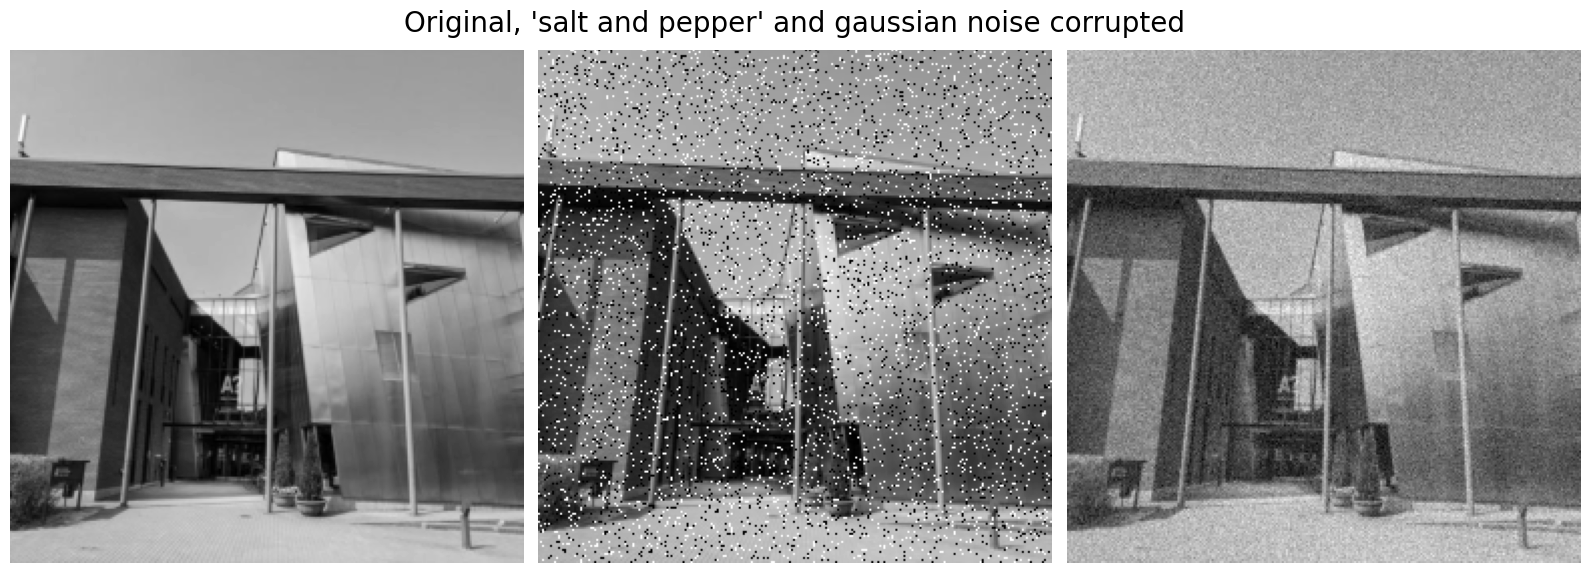

In [3]:
## Load test images.
## Note: Must be double precision in the interval [0,1].
im = rgb2gray(imread(data_dir+'/department2.jpg')) / 255.
im = resize(im, (256, 256))

## Add noise
## "salt and pepper" noise
imns = imnoise(im, 'salt & pepper', 0.05)
## zero-mean gaussian noise
imng = im + 0.05*np.random.randn(im.shape[0],im.shape[1])

# Display original and noise corrupted images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
ax = axes.ravel()
ax[0].imshow(im, cmap='gray')
ax[0].axis('off')
ax[1].imshow(imns, cmap='gray')
ax[1].axis('off')
ax[2].imshow(imng, cmap='gray')
ax[2].axis('off')
plt.tight_layout()
plt.suptitle("Original, 'salt and pepper' and gaussian noise corrupted", fontsize=20)
plt.subplots_adjust(top=1.2)
plt.show()

## Don't worry about the possible warnings below

### a) Gaussian filtering

In [4]:
## Apply Gaussian filter of std 2.5 
sigmad = 2.5
# g,_,_,_,_,_, = gaussian2(sigmad)

# gflt_imns = conv2(imns, g, mode='reflect')
# gflt_imng = conv2(imng, g, mode='reflect')

## Instead of directly filtering with g, make a separable implementation
## where you use horizontal and vertical 1D convolutions
## That is, replace the above two lines, you can use conv1 instead
## The result should not change.

##--your-code-starts-here--##

# Create 1D Gaussian kernel
x = np.linspace(-3*sigmad, 3*sigmad, int(6*sigmad + 1))
g1d = np.exp(-x**2 / (2*sigmad**2))
g1d /= g1d.sum()  # Normalize the kernel

# Horizontal convolution
gflt_imns_h = conv1(imns, g1d, axis=1, mode='reflect')
gflt_imng_h = conv1(imng, g1d, axis=1, mode='reflect')

# Vertical convolution (on top of the previous)
gflt_imns = conv1(gflt_imns_h, g1d, axis=0, mode='reflect')
gflt_imng = conv1(gflt_imng_h, g1d, axis=0, mode='reflect')

##--your-code-ends-here--##

### b) Median filtering

In [5]:
## Apply median filtering, use neighborhood size 5x5

##--your-code-starts-here--##

medflt_imns = median_filter(imns, size=5, mode='reflect')
medflt_imng = median_filter(imng, size=5, mode='reflect')

##--your-code-ends-here--##


### c) Bilateral filtering

In [6]:
def bilateral_filter(img, wsize, sigma_d, sigma_r):
##--your-code-starts-here--##

    rows, cols = img.shape
    output = np.zeros_like(img)

    # Spatial Gaussian filter
    half_wsize = wsize // 2
    x, y = np.meshgrid(np.arange(-half_wsize, half_wsize+1), np.arange(-half_wsize, half_wsize+1))
    spatial_filter = np.exp(-(x**2 + y**2) / (2 * sigma_d**2))

    # Bilateral filtering
    for i in range(rows):
        for j in range(cols):
            # Local region of the pixel
            i_min = max(i - half_wsize, 0)
            i_max = min(i + half_wsize + 1, rows)
            j_min = max(j - half_wsize, 0)
            j_max = min(j + half_wsize + 1, cols)

            # Local region of the image
            local_region = img[i_min:i_max, j_min:j_max]

            # Intensity differences
            intensity_diff = local_region - img[i, j]

            # Range filter
            range_filter = np.exp(-(intensity_diff**2) / (2 * sigma_r**2))

            # Bilateral filter (combination)
            combined_filter = spatial_filter[i_min-i+half_wsize:i_max-i+half_wsize, 
                                             j_min-j+half_wsize:j_max-j+half_wsize] * range_filter

            # Filter and normalize
            output[i, j] = np.sum(local_region * combined_filter) / np.sum(combined_filter)



##--your-code-ends-here--##
    return output


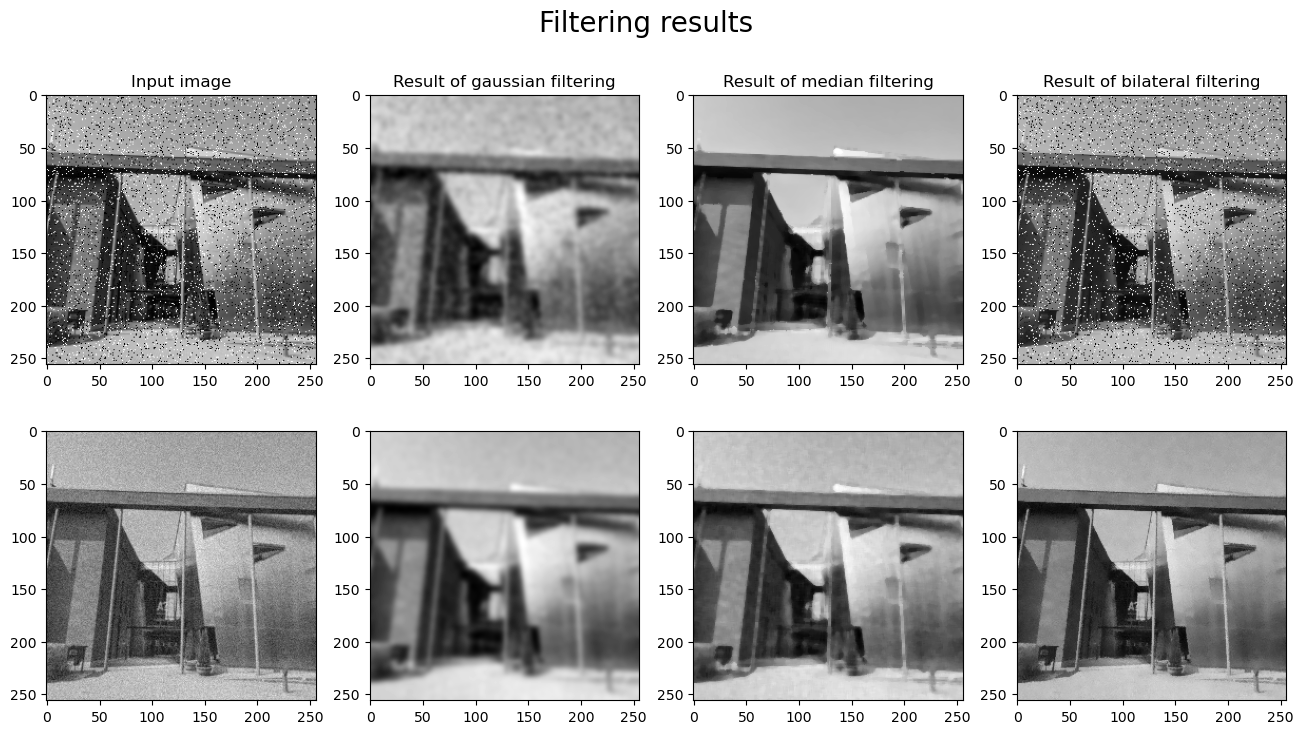

In [7]:
## Apply bilateral filter to each image and (uncomment the function calls once
## its definition is ready)

## You need to implement bilateralfilter function above.
## Use formulas (3.34)-(3.37) from Szeliski's book.
## You may freely decide in which mode ('full', 'valid', or 'same') your
## function runs (only one implementation enough), but note that with 'full' and 'same'
## you need to take care how the borders are handled (padded).

## Set bilateral filter parameters.
wsize = 11
sigma_d = 2.5
sigma_r = 0.1

bflt_imns = bilateral_filter(imns, wsize, sigma_d, sigma_r)
bflt_imng = bilateral_filter(imng, wsize, sigma_d, sigma_r)

# Display filtering results
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
ax = axes.ravel()
ax[0].imshow(imns, cmap='gray')
ax[0].set_title("Input image")
ax[1].imshow(gflt_imns, cmap='gray')
ax[1].set_title("Result of gaussian filtering")
ax[2].imshow(medflt_imns, cmap='gray')
ax[2].set_title("Result of median filtering")
ax[3].imshow(bflt_imns, cmap='gray')
ax[3].set_title("Result of bilateral filtering")
ax[4].imshow(imng, cmap='gray')
ax[5].imshow(gflt_imng, cmap='gray')
ax[6].imshow(medflt_imng, cmap='gray')
ax[7].imshow(bflt_imng, cmap='gray')
plt.suptitle("Filtering results", fontsize=20)
plt.show()

## Exercise 2 - Hybrid images
In  this  task  you  will  need  to  construct  a  hybrid  image  that  combines  facial images  of  a  wolf  and  a  man.  In  addition,  visualize  the  log  magnitudes  of  the  Fourier transforms  of  the  original  images  and  their  low-pass  and  high-pass  filtered  versions  (i.e.constituents  of  the  hybrid  image).<br><br>(Hint:  You  can  use  the  numpy.fft's  functions fft2 and fftshift as  shown  in  lecture  slides.)

In [8]:
## Load test images
man = imread(data_dir+'/man.jpg') / 255.
wolf = imread(data_dir+'/wolf.jpg') / 255.

# the pixel coordinates of eyes and chin have been manually found 
# from both images in order to enable affine alignment 
man_eyes_chin=np.array([[452, 461], [652, 457], [554, 823]])
wolf_eyes_chin=np.array([[851, 919], [1159, 947], [975, 1451]])
A, b = affinefit(man_eyes_chin, wolf_eyes_chin)

xv, yv = np.meshgrid(np.arange(0, man.shape[1]), np.arange(0, man.shape[0]))
pt = np.dot(A, np.vstack([xv.flatten(), yv.flatten()])) + np.tile(b, (xv.size,1)).T
wolft = map_coordinates(wolf, (pt[1,:].reshape(man.shape), pt[0,:].reshape(man.shape)))

## Below we simply blend the aligned images using additive superimposition
additive_superimposition = man + wolft

## Next we create two different Gaussian kernels for low-pass filtering
## the two images


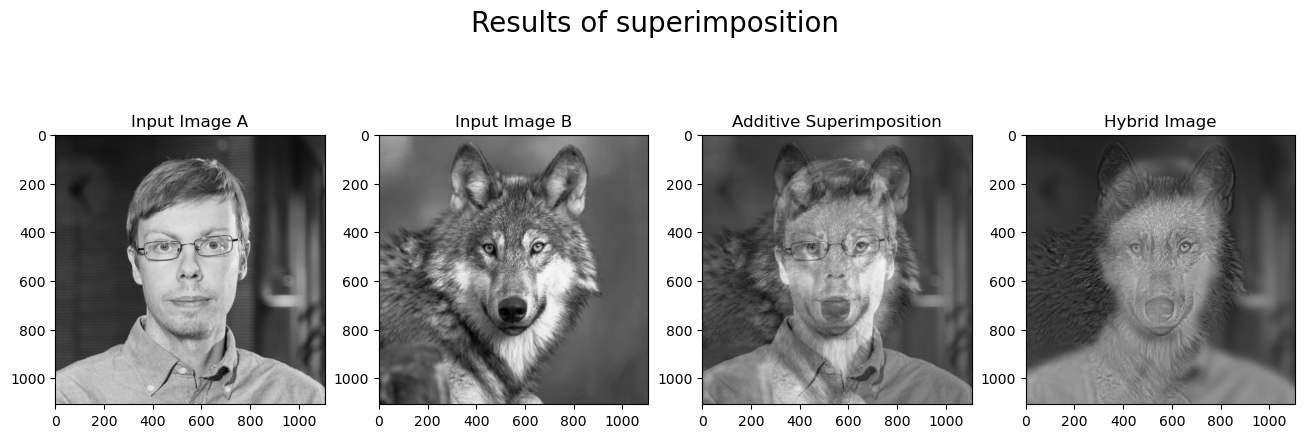

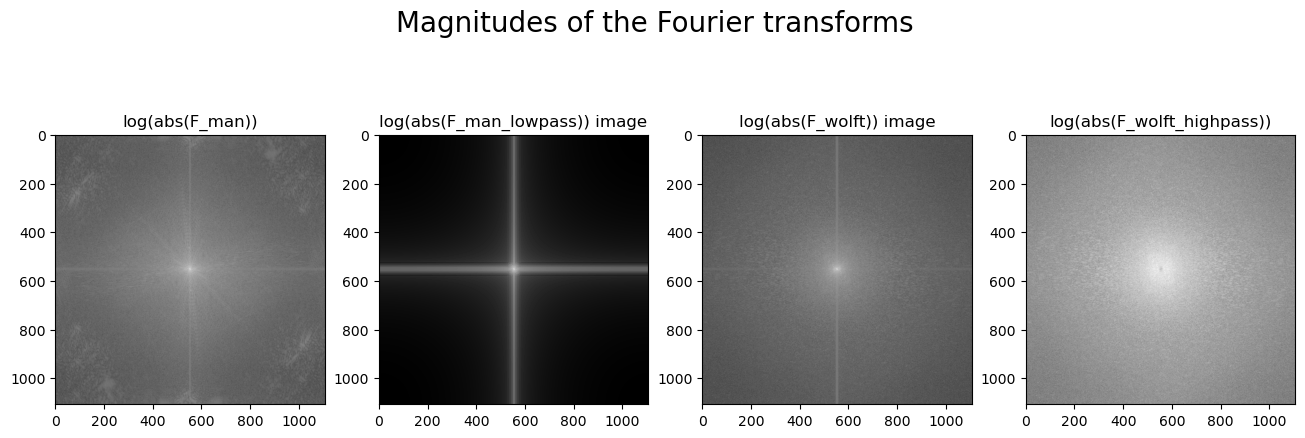

In [9]:
# naive blending by additive superimposition for illustration
superimpose = man + wolft

# low-pass filter the two images using two different Gaussian kernels
sigmaA = 16
sigmaB = 8
man_lowpass = gaussian_filter(man, sigmaA, mode='nearest')
wolft_lowpass = gaussian_filter(wolft, sigmaB, mode='nearest')
# We use gaussian_filter above in this case as it is significantly faster than the way below
#filterA,_,_,_,_,_, = gaussian2(sigmaA)
#filterB,_,_,_,_,_, = gaussian2(sigmaB)
#man_lowpass = conv2(man, filterA, mode='reflect')
#wolft_lowpass = conv2(wolft, filterB, mode='reflect')

## Your task is to create a hybrid image by combining a low-pass filtered 
## version of the human face with a high-pass filtered wolf face
 
## HINT: You get a high-pass version by subtracting the low-pass filtered version
## from the original image. Experiment also by trying different values for
## 'sigmaA' and 'sigmaB' above.
 
## Thus, your task is to replace the zero image on the following line
## with a high-pass filtered version of 'wolft'
# wolft_highpass = np.zeros(man_lowpass.shape);

##--your-code-starts-here--##

wolft_highpass = wolft - wolft_lowpass

##--your-code-ends-here--##
 
## Replace also the zero image below with the correct hybrid image
#hybrid_image = np.zeros(man_lowpass.shape)

##--your-code-starts-here--##

hybrid_image = man_lowpass + wolft_highpass

##--your-code-ends-here--##
 
## Notice how strongly the interpretation of the hybrid image is affected 
## by the viewing distance

## Display input images and both output images.
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,8))
plt.suptitle("Results of superimposition", fontsize=20)
ax = axes.ravel()
ax[0].imshow(man, cmap='gray')
ax[0].set_title("Input Image A")
ax[1].imshow(wolft, cmap='gray')
ax[1].set_title("Input Image B")
ax[2].imshow(additive_superimposition, cmap='gray')
ax[2].set_title("Additive Superimposition")
ax[3].imshow(hybrid_image, cmap='gray')
ax[3].set_title("Hybrid Image")
plt.subplots_adjust(top=1.2)
plt.show()

## Finally, visualize the log magnitudes of the Fourier
## transforms of the original images

##--your-code-starts-here--##

F_man = fftshift(fft2(man))
F_man_lowpass = fftshift(fft2(man_lowpass))
F_wolft = fftshift(fft2(wolft))
F_wolft_highpass = fftshift(fft2(wolft_highpass))

##--your-code-ends-here--##

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,8))
plt.suptitle("Magnitudes of the Fourier transforms", fontsize=20)
ax = axes.ravel()

ax[0].imshow(np.log(np.abs(F_man)), cmap='gray')
ax[0].set_title("log(abs(F_man))")
ax[1].imshow(np.log(np.abs(F_man_lowpass)), cmap='gray')
ax[1].set_title("log(abs(F_man_lowpass)) image")
ax[2].imshow(np.log(np.abs(F_wolft)), cmap='gray')
ax[2].set_title("log(abs(F_wolft)) image")
ax[3].imshow(np.log(np.abs(F_wolft_highpass)), cmap='gray')
ax[3].set_title("log(abs(F_wolft_highpass))")
plt.subplots_adjust(top=1.2)
plt.show() 

## Exercise 3 - Image blending
Go through the final part of this notebook and see the instructions in the comments of the source code. The example  implements Laplacian pyramid blending and blends facial images of a wolf and a man. The blending process is described  in Section 3.5.5 of Szeliski’s book. You need to implement the generation procedure for Gaussian and Laplacian image pyramids and the reconstruction procedure for reconstructing an image from its Laplacian pyramid.

(Hint: You can use two 1D convolutions with the binomial filter kernel g = [1 4 6 4 1]/16
to implement the low-pass filter before downsampling. Interpolation in the reconstruction
procedure can be performed by adding zeros between the rows and columns of the lower
resolution image and then filtering horizontally and
vertically with the kernel 2g as mentioned in Figure 3.33 of Szeliski’s book.)

In [10]:
## Implement missing functions: 
## generateLaplacianPyramid and reconstLaplacianPyramid
 
## Notice that in this implementation the first level of a Gaussian pyramid 
## is the original image, and the last level of a Laplacian pyramid is the
## same as the corresponding level in the Gaussian pyramid.

man = imread(data_dir+'/man_color.jpg') / 255.
man = resize(man, (int(man.shape[0] / 2), int(man.shape[1] / 2)))

wolf = imread(data_dir+'/wolf_color.jpg') / 255.
wolf = resize(wolf, (int(wolf.shape[0] / 2), int(wolf.shape[1] / 2)))

# the pixel coordinates of eyes and chin have been manually found 
# from both images in order to enable affine alignment 
man_eyes_chin=np.array([[452, 461], [652, 457], [554, 823]])
wolf_eyes_chin=np.array([[851, 919], [1159, 947], [975, 1451]])
A, b = affinefit(man_eyes_chin, wolf_eyes_chin)

xv, yv = np.meshgrid(np.arange(0, man.shape[1]), np.arange(0, man.shape[0]))
pt = np.dot(A, np.vstack([xv.flatten(), yv.flatten()])) + np.tile(b, (xv.size, 1)).T

wolft = np.zeros(man.shape)

for ch in range(3):
    wolft[:,:,ch] = map_coordinates(wolf[:,:,ch], (pt[1, :].reshape(man.shape[:2]),
                               pt[0, :].reshape(man.shape[:2])))


## Manually defined binary mask with an elliptical shape is constructed
## as well as its complement
x0=553.
y0=680.
a=160. 
b=190.
pixmask = (((xv-x0) / a) ** 2 + ((yv-y0) / b) ** 2) < 1

maskb = np.zeros(man.shape)
maskbw = np.zeros(man.shape[:2])
maskbw[pixmask] = 1.0
for c in range(3):
     maskb[:, :, c] = maskbw
maska = 1.0 - maskb

imga = resize(man, (1024,1024))
imgb = resize(wolft, (1024, 1024))
maska = resize(maska, (1024, 1024))
maskb = resize(maskb, (1024, 1024))            

In [11]:
def generateLaplacianPyramid(im, ptype, levels):
    ##--your-code-starts-here--##

    gaussianpyramid = [im]  # Start with the original image
    laplacianpyramid = []

    # Gaussian Pyramid
    for i in range(1, levels):
        downsampled = gaussian_filter(gaussianpyramid[i - 1], sigma=2)
        downsampled = downsampled[::2, ::2]  # Reduce resolution
        gaussianpyramid.append(downsampled)

    # Laplacian Pyramid
    for i in range(levels - 1):
        expanded = np.repeat(np.repeat(gaussianpyramid[i + 1], 2, axis=0), 2, axis=1)
        expanded = gaussian_filter(expanded, sigma=2)
        laplacian = gaussianpyramid[i] - expanded
        laplacianpyramid.append(laplacian)

    # Last level addition
    laplacianpyramid.append(gaussianpyramid[-1])
    
    ##--your-code-ends-here--## 
    if ptype == 'laplacian':
        return laplacianpyramid
    elif ptype == 'gaussian':
        return gaussianpyramid
    else:
        raise ValueError('Unknown pyramid type: ' + str(ptype))

In [12]:
def reconstLaplacianPyramid(lpyramid):
    ##--your-code-starts-here--## 
    
    # Function needs to work for both cases: lpyramid as a list and as a dict
    if isinstance(lpyramid, list):
        
        max_level = len(lpyramid) - 1
        im = lpyramid[max_level]
        
        for i in range(max_level - 1, -1, -1):
            # Upsample the current image
            expanded = np.repeat(np.repeat(im, 2, axis=0), 2, axis=1)
            expanded = gaussian_filter(expanded, sigma=2)
            im = expanded + lpyramid[i]
            
    elif isinstance(lpyramid, dict):
        max_level = max(lpyramid.keys())
        im = lpyramid[max_level]
        
        for i in range(max_level - 1, -1, -1):
            # Upsample the current image
            expanded = np.repeat(np.repeat(im, 2, axis=0), 2, axis=1)
            expanded = gaussian_filter(expanded, sigma=2)
            im = expanded + lpyramid[i]
    
    else: 
        raise TypeError("lpyramid can only be list or dict.")
        
    ##--your-code-ends-here--## 
    return im

Reconstruction error: 2.220446049250313e-16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


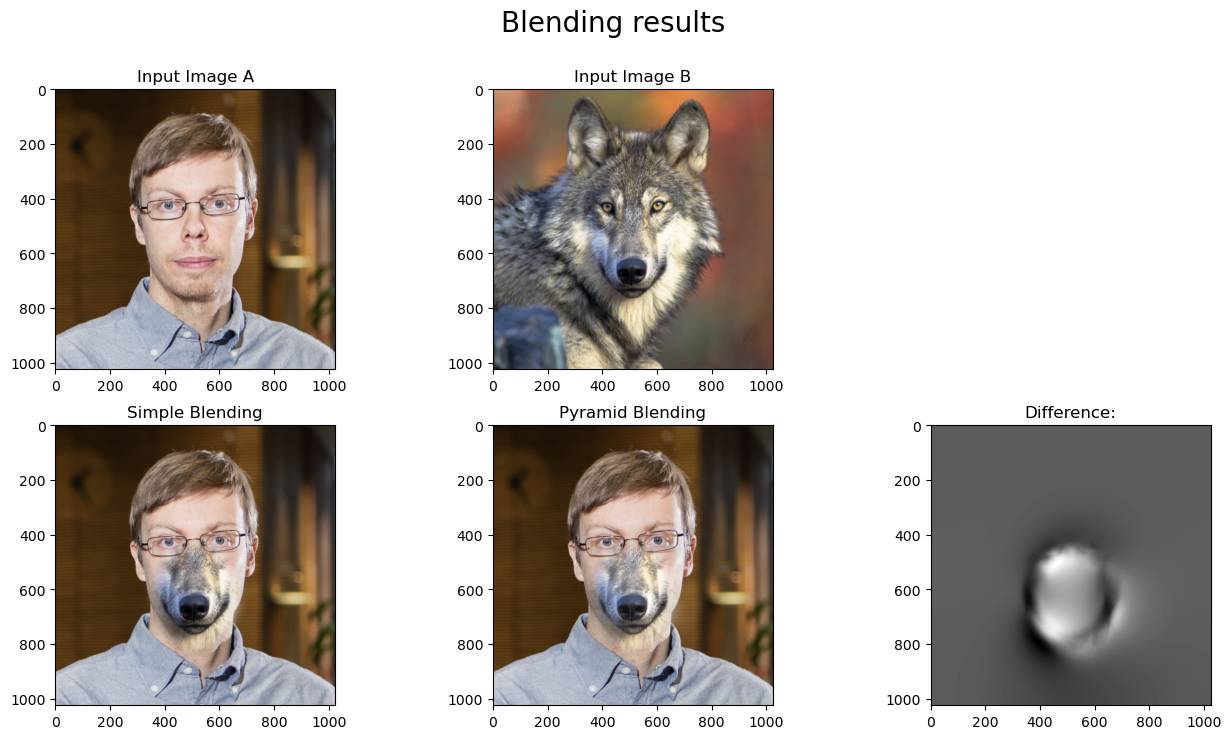

In [13]:
level = 8
 
## Make Laplacian image pyramids with 8 levels.
## Output is cell array (i.e. lpimga{i} is the Laplacian image at level i).
## The image at the final level is the base level image from the
## corresponding Gaussian pyramid.
## In the version below the second input is either 'laplacian' or 'gaussian',
## and it defines whether to output Laplacian or Gaussian pyramid.
## After you have implemented the functions above you can uncomment the lines below
## to finally plot the lacking figures ('Pyramid Blending' and 'Difference')
lpimga = generateLaplacianPyramid(imga,'laplacian',level);
lpimgb = generateLaplacianPyramid(imgb,'laplacian',level);

## Just check that your pyramid and reconstruction both work
ima = reconstLaplacianPyramid(lpimga)
max_reconstruction_error = np.amax(np.abs(imga.flatten() - ima.flatten()))
print("Reconstruction error: {}".format(max_reconstruction_error))

## Make Gaussian image pyramids of the mask images, maska and maskb
gpmaska = generateLaplacianPyramid(maska,'gaussian',level);
gpmaskb = generateLaplacianPyramid(maskb,'gaussian',level);

# Make smooth masks in a simple manner for comparison
smaska = gaussian_filter(maska, 20)
smaskb = gaussian_filter(maskb, 20)

## In practice, you can also use the Gaussian pyramids of smoothed masks. 
## In this case, the blendings (simple & pyramid) will appear more similar.
gpsmaska = generateLaplacianPyramid(smaska,'gaussian',level); 
gpsmaskb = generateLaplacianPyramid(smaskb,'gaussian',level);

limgo = {} # the blended pyramid
for p in range(level):
    # Blend the Laplacian images at each level
    # (You can use either one of the two rows below.)
    # limgo[p] = (lpimga[p]*gpmaska[p] + lpimgb[p]*gpmaskb[p])/(gpmaska[p]+gpmaskb[p])
    limgo[p] = (lpimga[p]*gpsmaska[p] + lpimgb[p]*gpsmaskb[p])/(gpsmaska[p]+gpsmaskb[p])

# Reconstruct the blended image from its Laplacian pyramid  
imgo = reconstLaplacianPyramid(limgo);
 
## Simple blending with smooth masks
imgo1 = smaska*imga + smaskb*imgb

## Display results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
plt.suptitle("Blending results", fontsize=20)
ax = axes.ravel()

ax[0].imshow(imga, cmap='gray')
ax[0].set_title("Input Image A")
ax[1].imshow(imgb, cmap='gray')
ax[1].set_title("Input Image B")
ax[2].set_visible(False)
ax[3].imshow(imgo1, cmap='gray')
ax[3].set_title("Simple Blending")
ax[4].imshow(imgo, cmap='gray')
ax[4].set_title("Pyramid Blending")
ax[5].imshow(np.amax(imgo-imgo1, axis=2), cmap='gray')
ax[5].set_title("Difference:")
plt.show()